In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

transforms = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(1)], [0.5 for _ in range(1)]
        ),
    ]
)

dataset = datasets.MNIST(root = 'data/', train=True, download=False, transform = transforms)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [4]:

class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img+1, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            
            nn.Sigmoid()
        )
        self.embed = nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size) #makes additional channel?
        x = torch.cat([x, embedding], dim=1)
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g,num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )
        self.embed = nn.Embedding(num_classes, embed_size) #adding embedding to noise

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.net(x)

    

def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            
def gradient_penalty(critic, labels, real, fake, device = 'cpu'):
    batch_size, c, h, w = real.shape
    epsilon = torch.rand((batch_size, 1, 1, 1)).repeat(1,c,h,w).to(device)
    interpolated_images = real*epsilon + (1-epsilon)*fake
    
    
    #calculate critic scores
    mixed_scores=critic(interpolated_images, labels)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph = True,
        retain_graph = True,
    )[0]
    gradient= gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    
    gradient_penalty = torch.mean((gradient_norm -1)**2)
    return gradient_penalty

In [5]:
# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.00002
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 128
NUM_EPOCHS = 5
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
NUM_CLASSES = 10
GEN_EMBEDDING =100
LAMBDA_GP = 10

 11%|█         | 100/938 [00:22<03:05,  4.51it/s]

Epoch [1/5] Batch 100/938                   Loss D: 0.0000, loss G: 21.6028


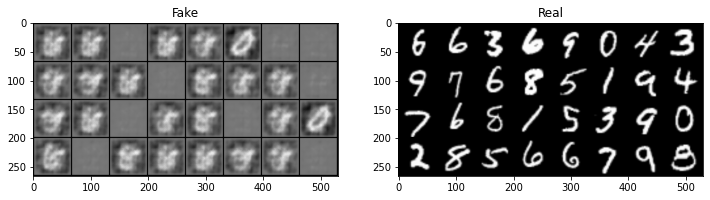

 21%|██▏       | 200/938 [00:44<02:43,  4.51it/s]

Epoch [1/5] Batch 200/938                   Loss D: 0.0000, loss G: 24.3077


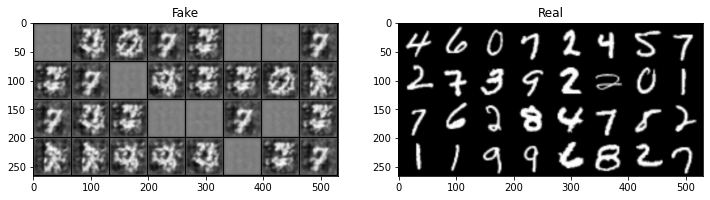

 32%|███▏      | 300/938 [01:07<02:23,  4.45it/s]

Epoch [1/5] Batch 300/938                   Loss D: 0.0001, loss G: 38.9855


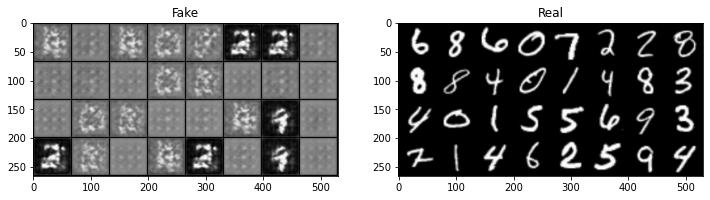

 43%|████▎     | 400/938 [01:29<02:00,  4.45it/s]

Epoch [1/5] Batch 400/938                   Loss D: 0.0003, loss G: 33.1632


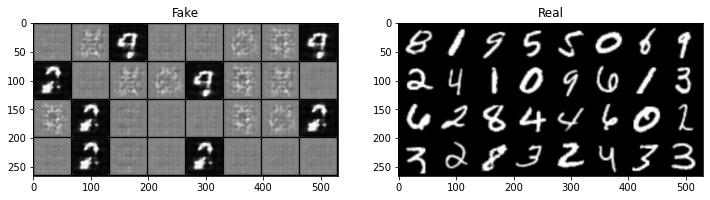

 53%|█████▎    | 500/938 [01:52<01:38,  4.44it/s]

Epoch [1/5] Batch 500/938                   Loss D: 0.0005, loss G: 26.0157


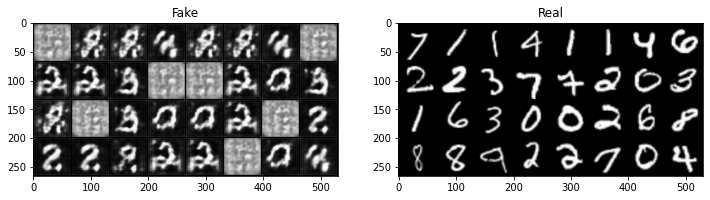

 64%|██████▍   | 600/938 [02:15<01:16,  4.44it/s]

Epoch [1/5] Batch 600/938                   Loss D: 0.0036, loss G: 24.4583


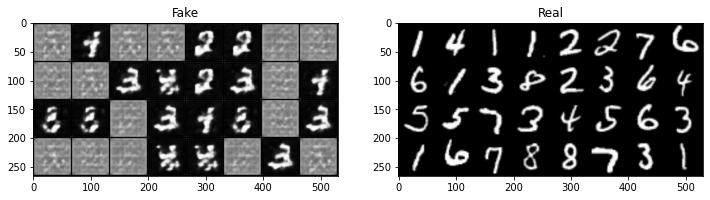

 75%|███████▍  | 700/938 [02:38<00:53,  4.43it/s]

Epoch [1/5] Batch 700/938                   Loss D: 0.0074, loss G: 14.7619


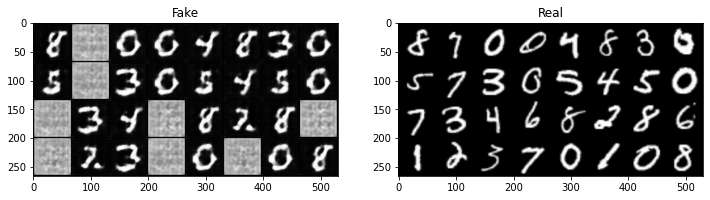

 85%|████████▌ | 800/938 [03:00<00:31,  4.42it/s]

Epoch [1/5] Batch 800/938                   Loss D: 0.0190, loss G: 5.0093


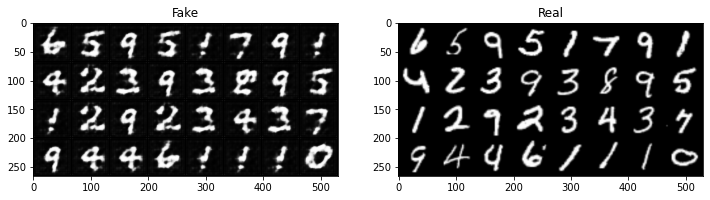

 96%|█████████▌| 900/938 [03:23<00:08,  4.42it/s]

Epoch [1/5] Batch 900/938                   Loss D: 0.0329, loss G: 4.5611


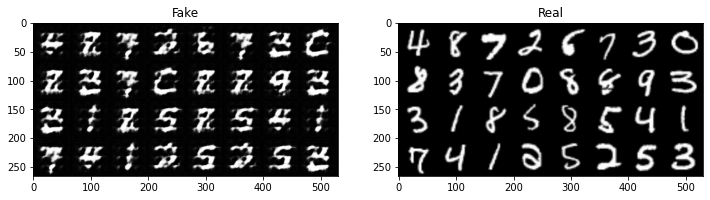

 11%|█         | 100/938 [00:22<03:09,  4.41it/s]

Epoch [2/5] Batch 100/938                   Loss D: 0.3204, loss G: 7.0833


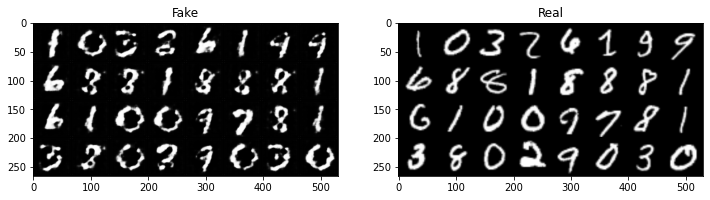

 21%|██▏       | 200/938 [00:45<02:46,  4.42it/s]

Epoch [2/5] Batch 200/938                   Loss D: 0.0643, loss G: 4.8275


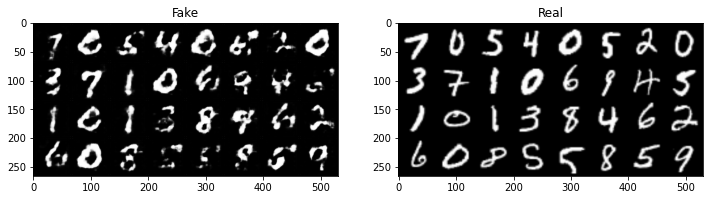

 32%|███▏      | 300/938 [01:08<02:24,  4.42it/s]

Epoch [2/5] Batch 300/938                   Loss D: 0.0858, loss G: 5.2312


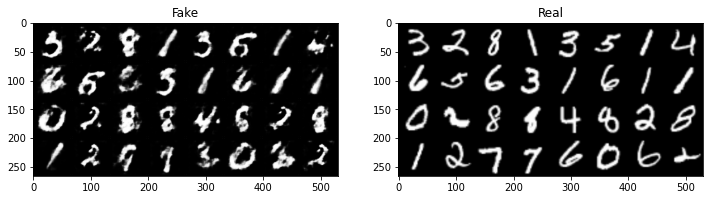

 43%|████▎     | 400/938 [01:31<02:01,  4.41it/s]

Epoch [2/5] Batch 400/938                   Loss D: 0.0668, loss G: 5.7277


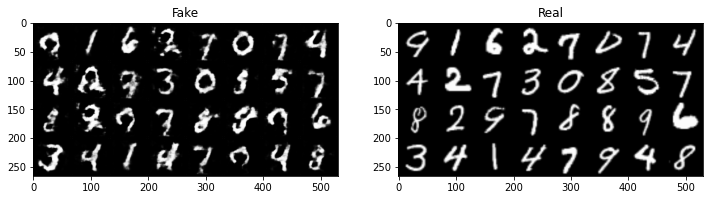

 53%|█████▎    | 500/938 [01:54<01:39,  4.41it/s]

Epoch [2/5] Batch 500/938                   Loss D: 0.0258, loss G: 6.3852


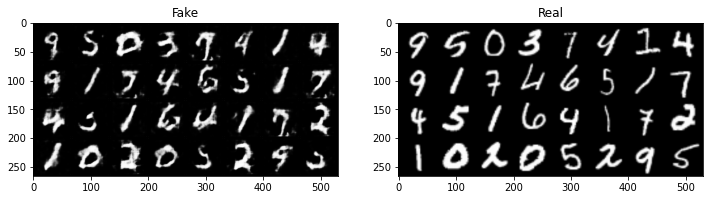

 64%|██████▍   | 600/938 [02:17<01:16,  4.41it/s]

Epoch [2/5] Batch 600/938                   Loss D: 0.0466, loss G: 5.7834


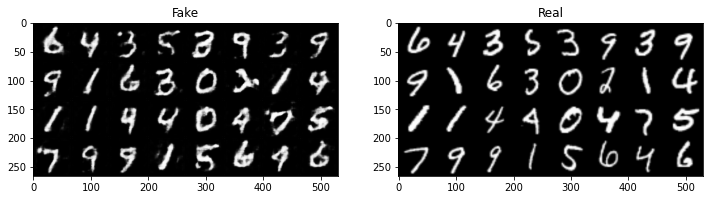

 75%|███████▍  | 700/938 [02:40<00:53,  4.41it/s]

Epoch [2/5] Batch 700/938                   Loss D: 0.0422, loss G: 5.6837


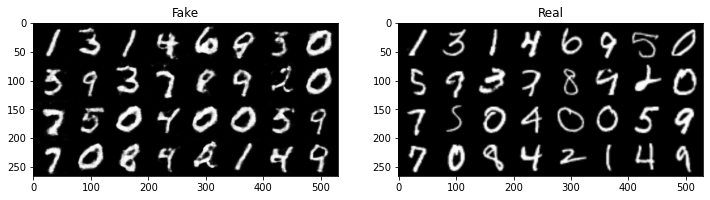

 85%|████████▌ | 800/938 [03:02<00:31,  4.41it/s]

Epoch [2/5] Batch 800/938                   Loss D: 0.0616, loss G: 7.6785


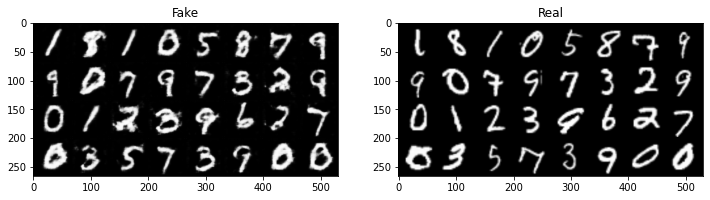

 96%|█████████▌| 900/938 [03:25<00:08,  4.41it/s]

Epoch [2/5] Batch 900/938                   Loss D: 0.0095, loss G: 6.8966


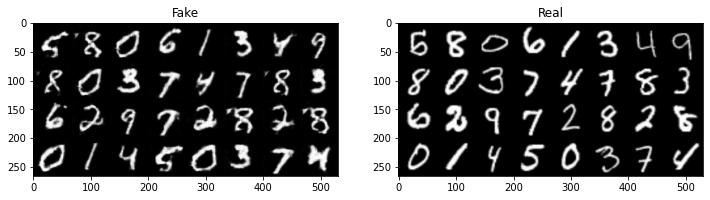

 11%|█         | 100/938 [00:51<10:11,  1.37it/s]

Epoch [3/5] Batch 100/938                   Loss D: 0.0203, loss G: 7.8260


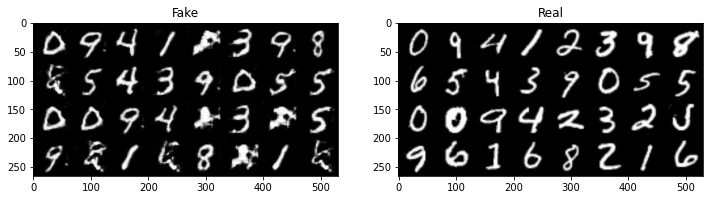

 21%|██▏       | 200/938 [01:25<02:47,  4.42it/s]

Epoch [3/5] Batch 200/938                   Loss D: 0.0032, loss G: 8.0454


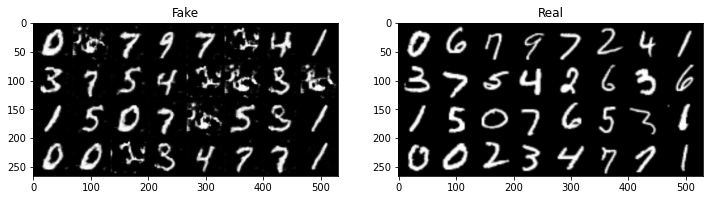

 32%|███▏      | 300/938 [01:47<02:24,  4.41it/s]

Epoch [3/5] Batch 300/938                   Loss D: 0.0096, loss G: 7.0232


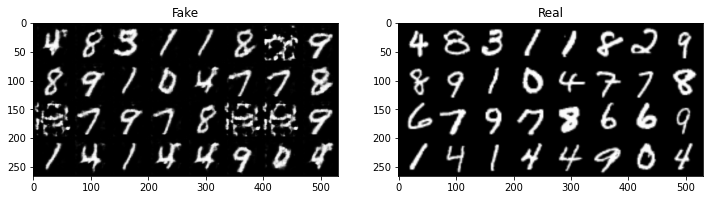

 43%|████▎     | 400/938 [02:10<02:01,  4.42it/s]

Epoch [3/5] Batch 400/938                   Loss D: 0.0017, loss G: 8.9390


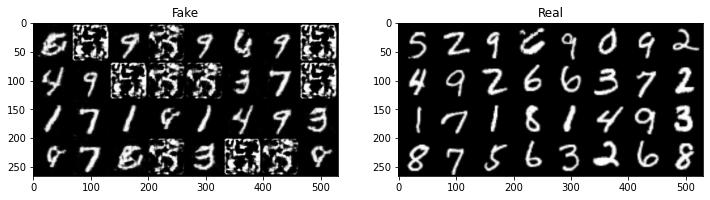

 53%|█████▎    | 500/938 [02:33<01:39,  4.42it/s]

Epoch [3/5] Batch 500/938                   Loss D: 0.0015, loss G: 8.6563


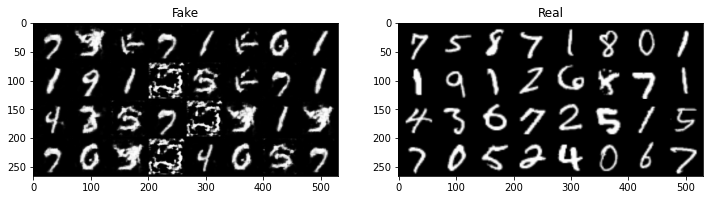

 64%|██████▍   | 600/938 [03:02<02:46,  2.03it/s]

Epoch [3/5] Batch 600/938                   Loss D: 0.0027, loss G: 8.4313


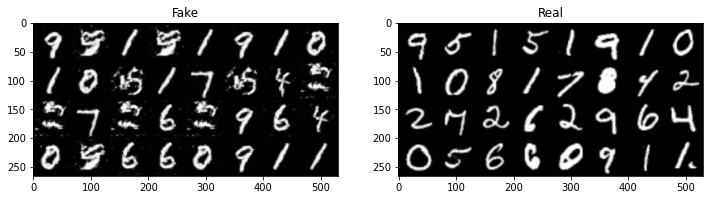

 75%|███████▍  | 700/938 [03:50<01:56,  2.05it/s]

Epoch [3/5] Batch 700/938                   Loss D: 0.0013, loss G: 8.3706


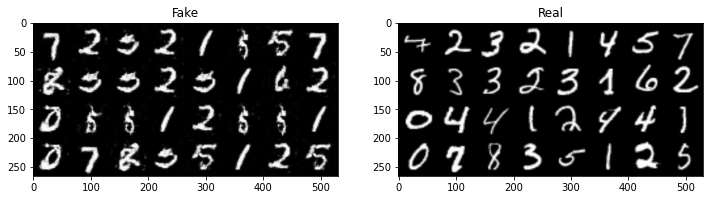

 85%|████████▌ | 800/938 [04:38<01:07,  2.05it/s]

Epoch [3/5] Batch 800/938                   Loss D: 0.0061, loss G: 10.0084


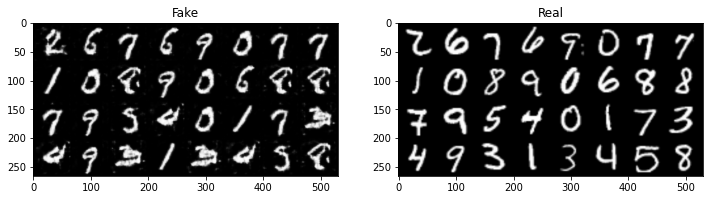

 96%|█████████▌| 900/938 [05:27<00:18,  2.09it/s]

Epoch [3/5] Batch 900/938                   Loss D: 0.0034, loss G: 8.6637


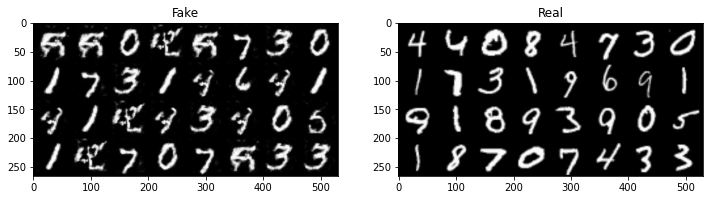

 11%|█         | 100/938 [00:48<06:33,  2.13it/s]

Epoch [4/5] Batch 100/938                   Loss D: 0.0870, loss G: 13.3722


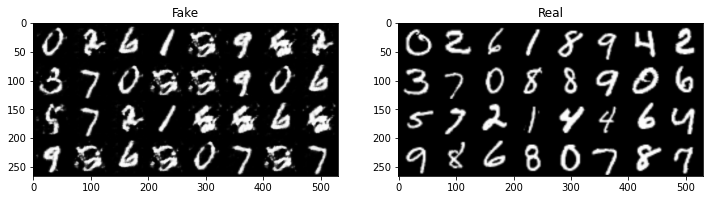

 21%|██▏       | 200/938 [01:36<05:31,  2.23it/s]

Epoch [4/5] Batch 200/938                   Loss D: 0.0012, loss G: 8.4594


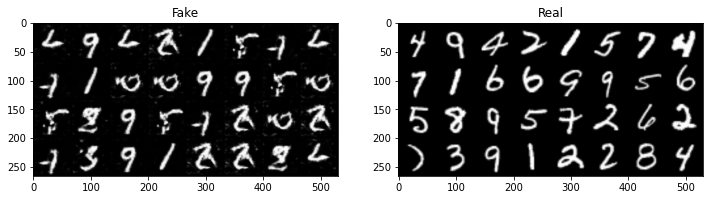

 32%|███▏      | 300/938 [02:24<05:22,  1.98it/s]

Epoch [4/5] Batch 300/938                   Loss D: 0.0021, loss G: 7.6163


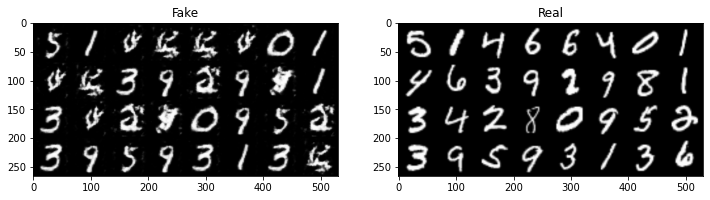

 43%|████▎     | 400/938 [03:12<04:27,  2.01it/s]

Epoch [4/5] Batch 400/938                   Loss D: 0.0032, loss G: 8.5363


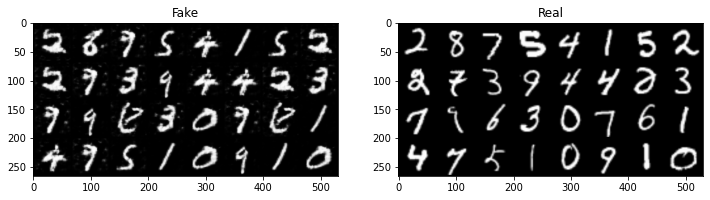

 53%|█████▎    | 500/938 [04:00<03:27,  2.11it/s]

Epoch [4/5] Batch 500/938                   Loss D: 0.0024, loss G: 8.6912


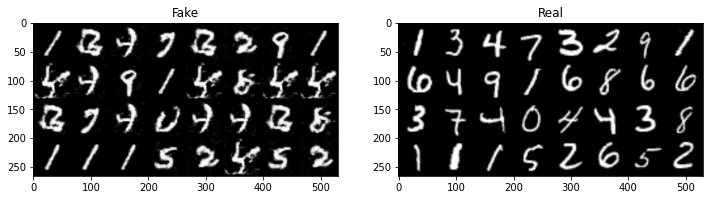

 64%|██████▍   | 600/938 [04:26<01:16,  4.42it/s]

Epoch [4/5] Batch 600/938                   Loss D: 0.0018, loss G: 7.7876


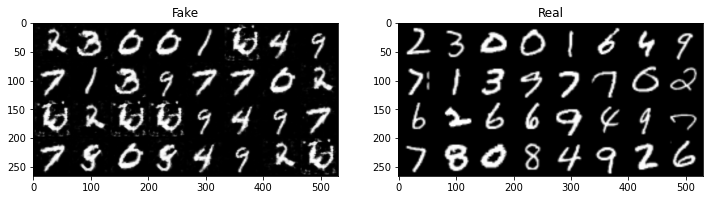

 75%|███████▍  | 700/938 [04:49<00:53,  4.42it/s]

Epoch [4/5] Batch 700/938                   Loss D: 0.0012, loss G: 8.4768


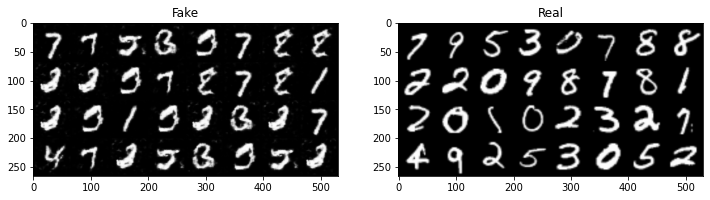

 85%|████████▌ | 800/938 [05:12<00:31,  4.43it/s]

Epoch [4/5] Batch 800/938                   Loss D: 0.0013, loss G: 8.1029


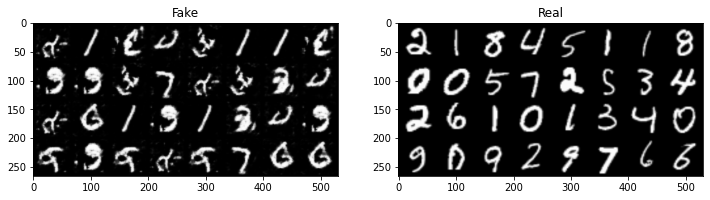

 96%|█████████▌| 900/938 [05:35<00:08,  4.42it/s]

Epoch [4/5] Batch 900/938                   Loss D: 0.0031, loss G: 7.4104


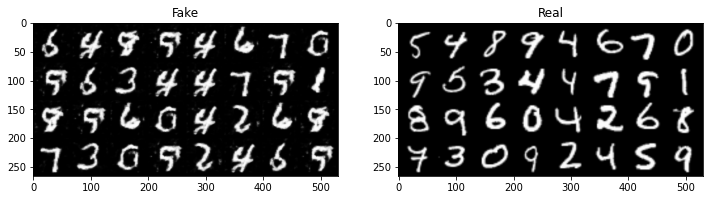

 11%|█         | 100/938 [00:22<03:09,  4.42it/s]

Epoch [5/5] Batch 100/938                   Loss D: 0.0033, loss G: 7.8268


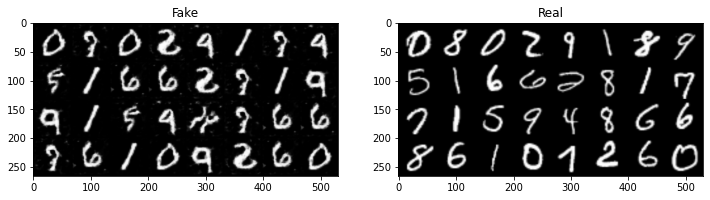

 21%|██▏       | 200/938 [00:45<02:47,  4.42it/s]

Epoch [5/5] Batch 200/938                   Loss D: 0.0024, loss G: 8.3652


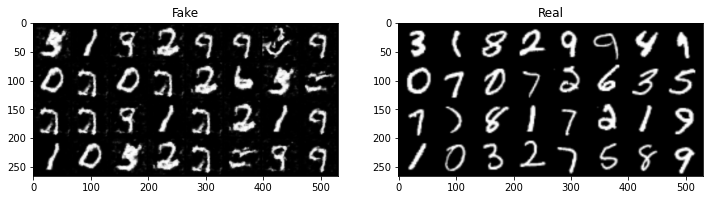

 32%|███▏      | 300/938 [01:09<02:28,  4.28it/s]

Epoch [5/5] Batch 300/938                   Loss D: 0.1459, loss G: 16.2231


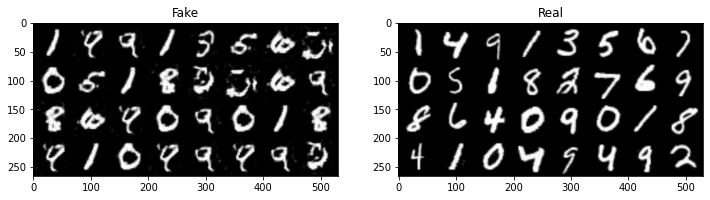

 43%|████▎     | 400/938 [01:32<02:01,  4.42it/s]

Epoch [5/5] Batch 400/938                   Loss D: 0.0012, loss G: 7.7154


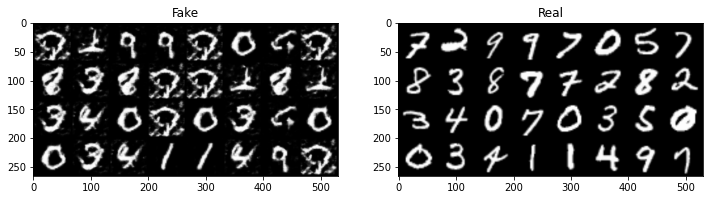

 53%|█████▎    | 500/938 [01:57<02:20,  3.12it/s]

Epoch [5/5] Batch 500/938                   Loss D: 0.0018, loss G: 10.5287


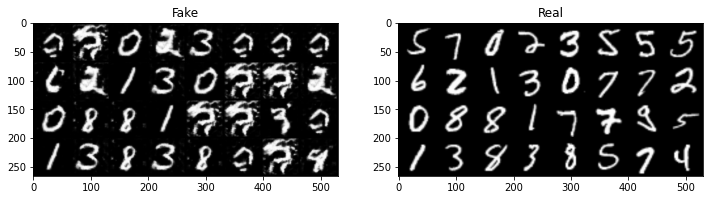

 64%|██████▍   | 600/938 [02:30<01:46,  3.18it/s]

Epoch [5/5] Batch 600/938                   Loss D: 0.0011, loss G: 7.6224


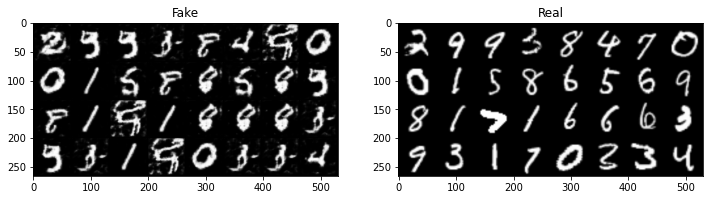

 75%|███████▍  | 700/938 [03:02<01:15,  3.13it/s]

Epoch [5/5] Batch 700/938                   Loss D: 0.0027, loss G: 9.2006


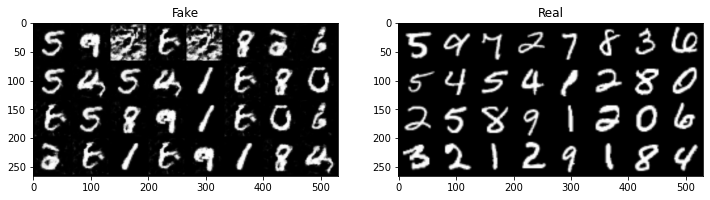

 85%|████████▌ | 800/938 [03:35<00:45,  3.05it/s]

Epoch [5/5] Batch 800/938                   Loss D: 0.3206, loss G: 13.9317


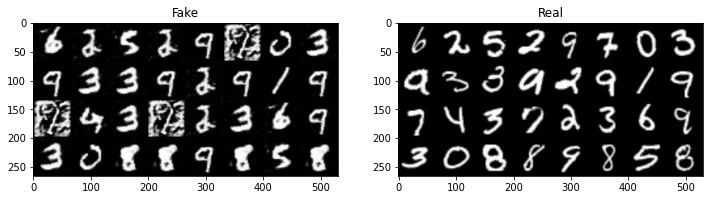

 96%|█████████▌| 900/938 [04:07<00:12,  2.98it/s]

Epoch [5/5] Batch 900/938                   Loss D: 0.0045, loss G: 7.6406


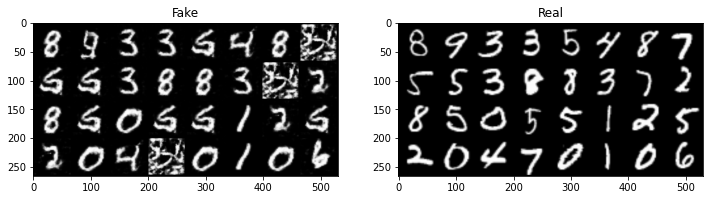

100%|██████████| 938/938 [04:20<00:00,  3.60it/s]


In [7]:
        
# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC, NUM_CLASSES, IMG_SIZE).to(device)
initialize_weights(gen)
initialize_weights(critic)
criterion = nn.BCELoss().to(device)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

step = 0

gen.train()
critic.train()
i=0
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, labels) in enumerate(tqdm(loader)):
        data = data.to(device)
        labels = labels.to(device)
        cur_batch_size = data.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise, labels)
#             print(labels)
            critic_real = critic(data,labels).reshape(-1)
            real_loss = criterion(critic_real,  torch.ones_like(critic_real))
            critic_fake = critic(fake,labels).reshape(-1)
            fake_loss = criterion(critic_fake, torch.zeros_like(critic_fake))
            loss_disc = real_loss + fake_loss
            
            critic.zero_grad()
            loss_disc.backward(retain_graph=True)
            opt_critic.step()
            
            
        output = critic(fake, labels).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        if batch_idx % 100 == 0 and batch_idx > 0:
            gen.eval()
            critic.eval()
            print(
                f"Epoch [{epoch+1}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(noise,labels)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    data[:32].cpu().detach(), normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32].cpu().detach(), normalize=True
                )
                fig, ax = plt.subplots(1,2, figsize= (12,6))
                ax[0].imshow(img_grid_fake.permute(1, 2, 0))
                ax[1].imshow(img_grid_real.permute(1,2,0))
                ax[0].set_title('Fake')
                ax[1].set_title('Real')
                plt.show()

            step += 1
            gen.train()
            critic.train()